In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

In [2]:
moving_files_dates = []
sleeping_files_dates = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/move/'):
    moving_files_dates.append(f[:6])
    
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/sleep/'):
    sleeping_files_dates.append(f[:6])

In [3]:
import pandas as pd
df_move = pd.DataFrame({'dates':moving_files_dates})
df_sleep = pd.DataFrame({'dates':sleeping_files_dates})

df = pd.concat([df_move, df_sleep])

In [4]:
df = df.value_counts().reset_index().rename(columns = {0:'counts'})
df['ind'] = 1

In [5]:
df['total']=df.groupby('ind').counts.transform(np.sum)

In [6]:
df = df.drop('ind', axis = 1)

In [7]:
df['percent_total'] = df['counts']/df['total']

In [8]:
df

dates  counts  total  percent_total
0   180327    2365  16085       0.147031
1   180413    1938  16085       0.120485
2   180409    1880  16085       0.116879
3   180330    1715  16085       0.106621
4   180331    1504  16085       0.093503
5   180414    1448  16085       0.090022
6   180412    1262  16085       0.078458
7   180329    1039  16085       0.064594
8   180401    1029  16085       0.063973
9   180411     781  16085       0.048555
10  180410     773  16085       0.048057
11  180326     351  16085       0.021822

In [9]:
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/move/'):
    print(np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/move/'+f).shape)
    break

(62, 10, 100)


# Making Datasets

In [10]:
moving_files_train = []
moving_files_val = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/move/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/move/'+f).shape[2] == 100:
        x = np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/move/'+f)
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        win = f.split('_')[3]
        if (('0327' not in f) and ('0330' not in f)):
            moving_files_train.append((torch.from_numpy(x), torch.Tensor([0]), date, rec, win))
        else:
            moving_files_val.append((torch.from_numpy(x), torch.Tensor([0]), date, rec, win))
        
sleeping_files_train = []
sleeping_files_val = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/sleep/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/sleep/'+f).shape[2] == 100:
        x = np.load('/mnt/pesaranlab/People/Capstone_students/Noah/datav5/sleep/'+f)
        date = f.split('_')[0]
        rec = f.split('_')[1].split('_')[0]
        win = f.split('_')[3]
        if (('0327' not in f) and ('0330' not in f)):
            sleeping_files_train.append((torch.from_numpy(x), torch.Tensor([1]), date, rec, win))
        else:
            sleeping_files_val.append((torch.from_numpy(x), torch.Tensor([1]), date, rec, win))

In [11]:
len(moving_files_train), len(sleeping_files_train)

(3801, 8204)

In [12]:
len(moving_files_val), len(sleeping_files_val)

(2091, 1989)

In [13]:
import random
diff_train = len(sleeping_files_train)-len(moving_files_train)
for i in range(diff_train):
    ind = random.randint(0,len(moving_files_train)-1)
    x= moving_files_train[ind]
    moving_files_train.append(x)

In [14]:
len(moving_files_train), len(sleeping_files_train)

(8204, 8204)

In [15]:
train_files = moving_files_train + sleeping_files_train
val_files = moving_files_val + sleeping_files_val

len(train_files)/(len(train_files)+len(val_files))

0.8008590394377196

In [16]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train',moving_files_train=moving_files_train,sleeping_files_train=sleeping_files_train,moving_files_val=moving_files_val,sleeping_files_val=sleeping_files_val):
        if mode == 'train':
            self.all_files = moving_files_train+sleeping_files_train
        elif mode == 'valid':
            self.all_files = moving_files_val+sleeping_files_val
            
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        return self.all_files[idx]

In [17]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')

In [18]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 16, shuffle = False)

In [19]:
for (data, labels, date, rec, win) in train_loader:
    print(type(data))
    break

<class 'torch.Tensor'>


# Checking data quality

printing all channels of first 5 batches
batch number: 0
label (move = 0, sleep = 1): tensor([0.])
date: 180414
recording: 007


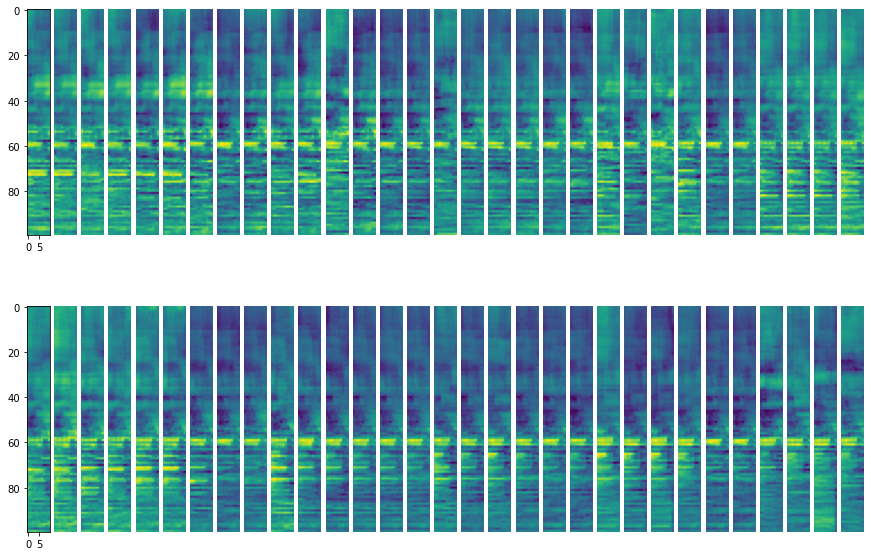

batch number: 1
label (move = 0, sleep = 1): tensor([0.])
date: 180412
recording: 006


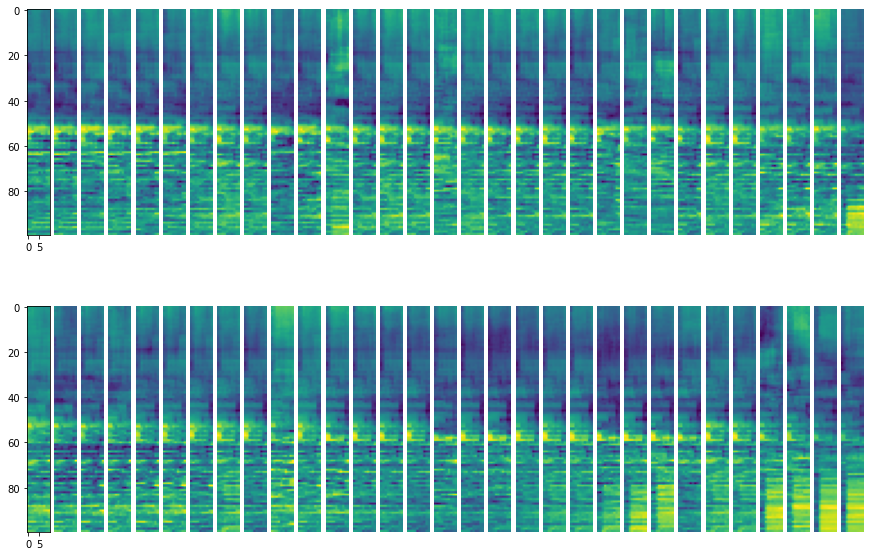

batch number: 2
label (move = 0, sleep = 1): tensor([0.])
date: 180414
recording: 007


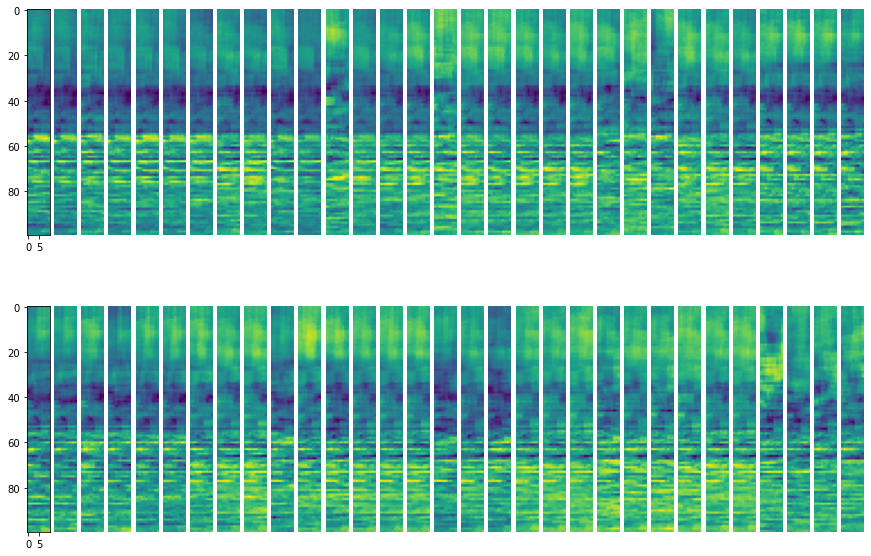

batch number: 3
label (move = 0, sleep = 1): tensor([0.])
date: 180413
recording: 003


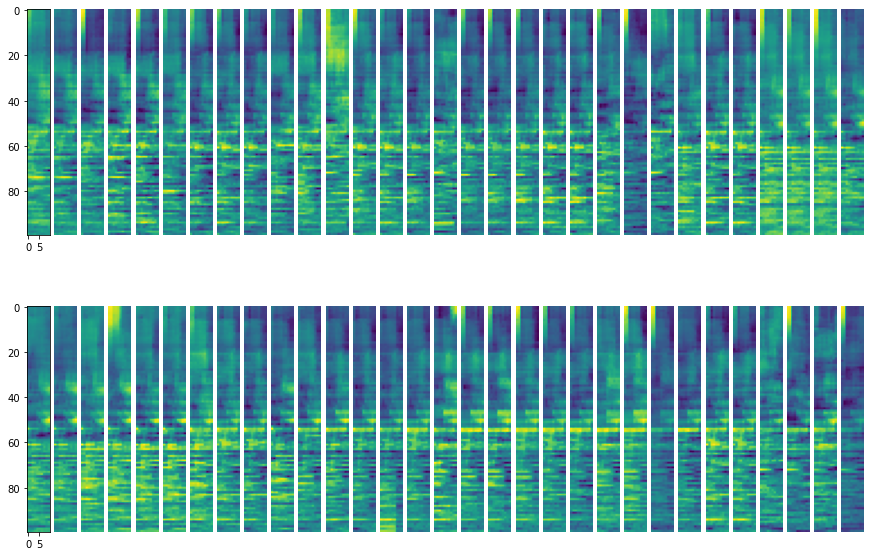

batch number: 4
label (move = 0, sleep = 1): tensor([1.])
date: 180409
recording: 001


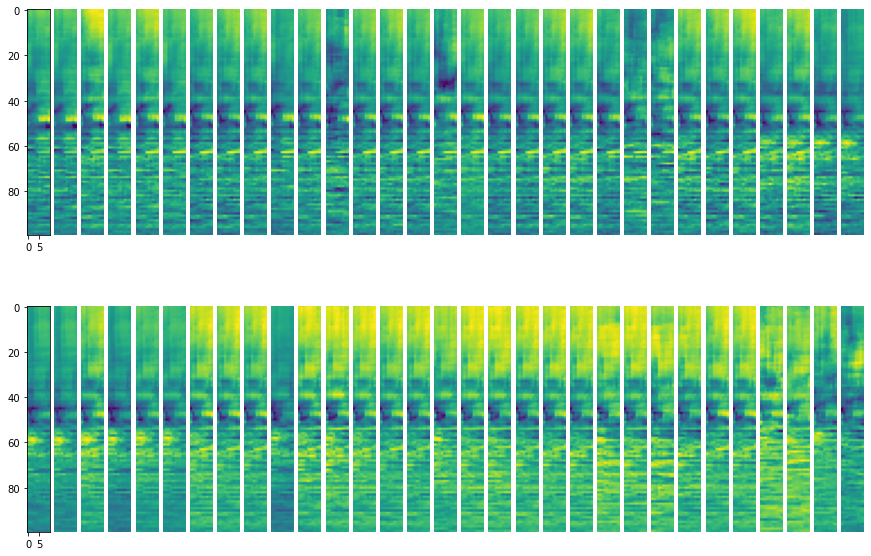

batch number: 5
label (move = 0, sleep = 1): tensor([0.])
date: 180414
recording: 007


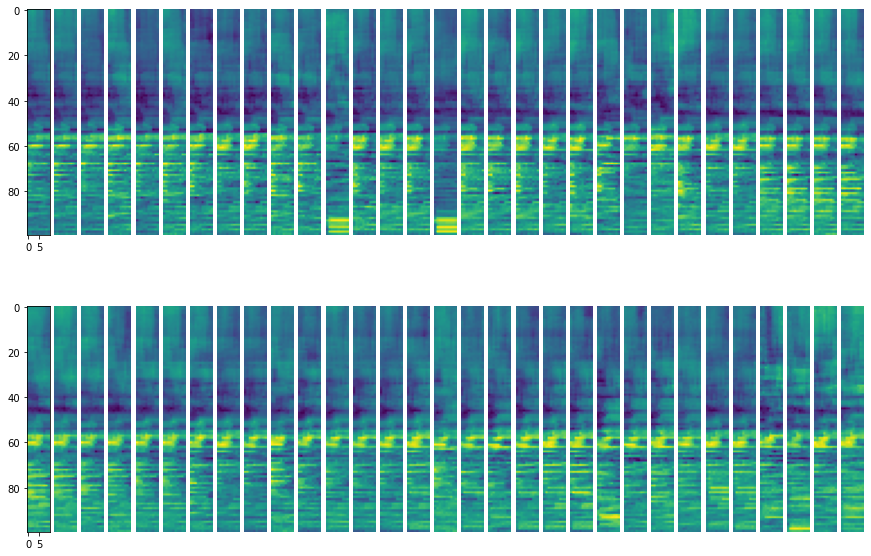

batch number: 6
label (move = 0, sleep = 1): tensor([0.])
date: 180413
recording: 001


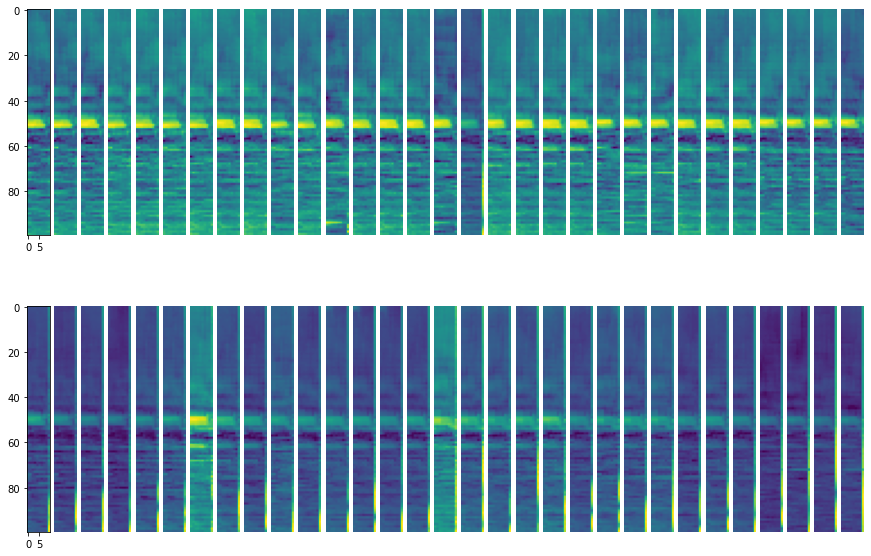

batch number: 7
label (move = 0, sleep = 1): tensor([1.])
date: 180411
recording: 005


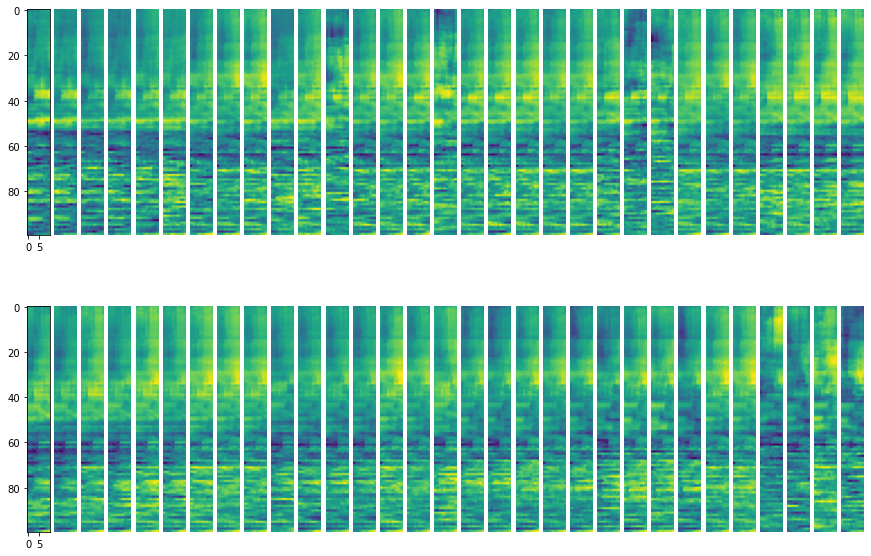

batch number: 8
label (move = 0, sleep = 1): tensor([1.])
date: 180412
recording: 001


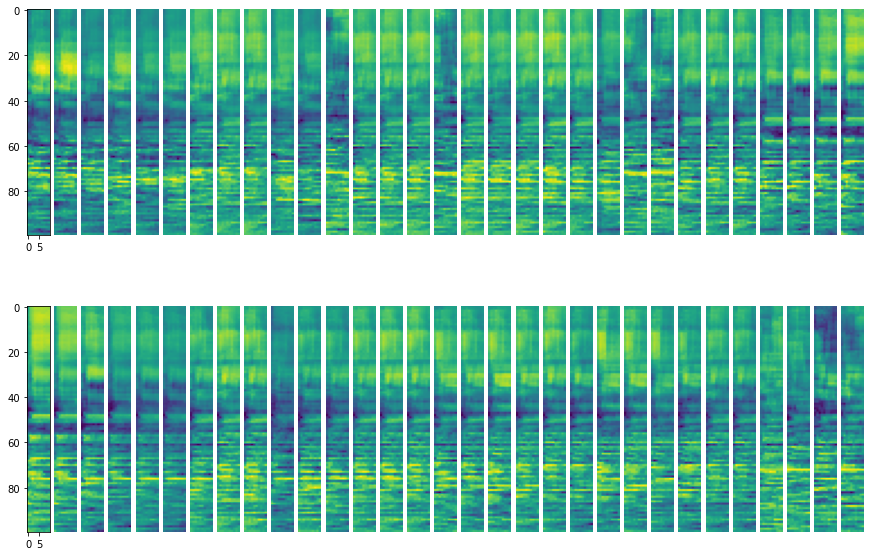

In [20]:
print('printing all channels of first 5 batches')
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    print('batch number: '+str(batch_idx))
    print('label (move = 0, sleep = 1): ' +str(labels[0]))
    print('date: '+str(date[0]))
    print('recording: '+str(rec[0]))
    plt.figure(figsize=(15,10))
    for channel in range(62):
        plt.subplot(2,31,channel+1)
        spec = data[0][channel].cpu().detach()
        plt.imshow(torch.transpose(spec,0,1))
        if (channel != 0) and (channel != 31):
            plt.axis('off')
    plt.show()
    if batch_idx == 8:
        break

# Train/Test Functions

In [21]:
def train(loader, epoch):
    model.train()
    batch_losses = []
    preds = []
    labs = []
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
            continue
#         if batch_idx % 50 == 0 and epoch == 0:
#             print('Showing Train Images')
#             print('batch number: '+str(batch_idx))
#             print('label (move = 0, sleep = 1): ' +str(labels[0]))
#             plt.figure(figsize=(15,10))
#             for channel in range(62):
#                 plt.subplot(2,32,channel+1)
#                 plt.imshow(data[0][channel].cpu().detach().numpy())
#                 if (channel != 0) and (channel != 32):
#                     plt.axis('off')
#             plt.show()
        
        optimizer.zero_grad()
    
        output, conv1, conv2 = model(data)
        loss = criterion(output.reshape(output.shape[0],-1), labels)
        
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
        predictions = []
        for o in output:
            if o.item() > .5:
                predictions.append(1)
            else:
                predictions.append(0)
        predictions = np.array(predictions)
        total += labels.size(0)
        correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
        preds.append(predictions.flatten())
        labs.append(labels.flatten().cpu().numpy())
        
    
    epoch_loss = sum(batch_losses)/len(batch_losses)
    accuracy = correct / total
    
    return epoch_loss, accuracy, preds, labs

In [22]:
def test(loader, epoch):
    model.eval()
    batch_losses = []
    preds = []
    labs = []
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels, date, rec, win) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
#             if batch_idx % 10 == 0 and epoch == 0:
#                 print('Showing Val Images')
#                 print('Showing Train Images')
#                 print('batch number: '+str(batch_idx))
#                 print('label (move = 0, sleep = 1): ' +str(labels[0]))
#                 plt.figure(figsize=(15,10))
#                 for channel in range(62):
#                     plt.subplot(2,32,channel+1)
#                     plt.imshow(data[0][channel].cpu().detach().numpy())
#                     if (channel != 0) and (channel != 32):
#                         plt.axis('off')
#                 plt.show()
            
            output, conv1, conv2 = model(data)
            loss = criterion(output, labels)
            
            batch_losses.append(loss)
            
            #get accuracy
            predictions = []
            for o in output:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
            preds.append(predictions.flatten())
            labs.append(labels.flatten().cpu().numpy())
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        accuracy = correct/total
        
        return epoch_loss, accuracy, preds, labs

# Standard 4 layer CNN

In [21]:
input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [24]:
class CNN_4layer(nn.Module):
    def __init__(self, num_classes = 1):
        super(CNN_4layer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=62, out_channels=124, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=124, out_channels=248, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv3 = nn.Conv2d(in_channels=248, out_channels=496, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv4 = nn.Conv2d(in_channels=496, out_channels=992, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(992*10*100, num_classes)
#         self.fc1 = nn.Linear(248*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
        x = relu(self.conv3(x2))
        x = relu(self.conv4(x))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [28]:
model = CNN_4layer().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.91 GiB total capacity; 236.74 MiB already allocated; 16.81 MiB free; 252.00 MiB reserved in total by PyTorch)

NameError: name 'training_losses' is not defined

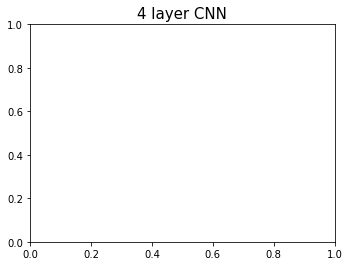

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("4 layer CNN", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("4 layer CNN", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [116]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

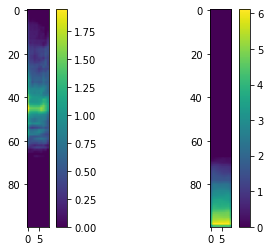

In [117]:
weights = conv1[0]
# plt.figure(figsize=(30,90))
for i in range(2):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,2,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

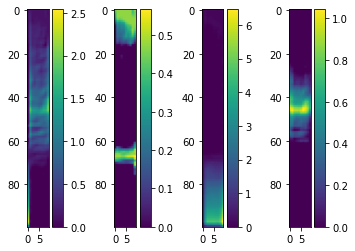

In [118]:
weights = conv2[0]
# plt.figure(figsize=(30,90))
for i in range(4):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,4,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

# Smaller 2 layer CNN

In [23]:
class CNN_2layer(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN_2layer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=62, out_channels=124, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=124, out_channels=248, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(248*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
        x = x2.reshape(x2.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [25]:
input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.001
num_epochs = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
model = CNN_2layer().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.37214910984039307
Val loss for epoch 0: 0.3418411314487457
Train loss for epoch 1: 0.20707209408283234
Val loss for epoch 1: 0.2551700472831726
Train loss for epoch 2: 0.16085562109947205
Val loss for epoch 2: 0.2986169457435608
Train loss for epoch 3: 0.12088484317064285
Val loss for epoch 3: 0.3487556278705597
Train loss for epoch 4: 0.20048712193965912
Val loss for epoch 4: 0.5814526677131653
Train loss for epoch 5: 0.07477615773677826
Val loss for epoch 5: 0.3755306303501129
Train loss for epoch 6: 0.08958293497562408
Val loss for epoch 6: 0.6086012125015259
Train loss for epoch 7: 0.07626901566982269
Val loss for epoch 7: 1.5717685222625732
Train loss for epoch 8: 0.09277200698852539
Val loss for epoch 8: 0.8267410397529602
Train loss for epoch 9: 0.03820616379380226
Val loss for epoch 9: 1.2134402990341187
Train loss for epoch 10: 0.0711197629570961
Val loss for epoch 10: 1.2638134956359863
Train loss for epoch 11: 0.04230055212974548
Val loss for epoch 

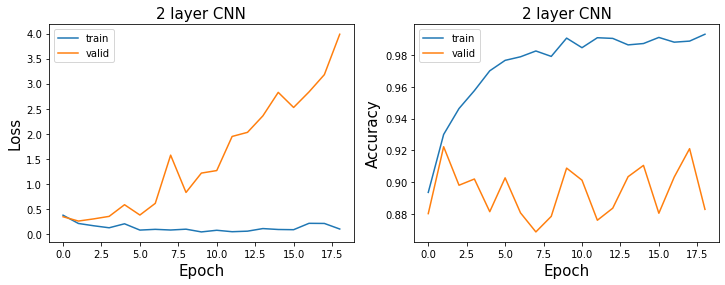

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("2 layer CNN", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("2 layer CNN", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [27]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

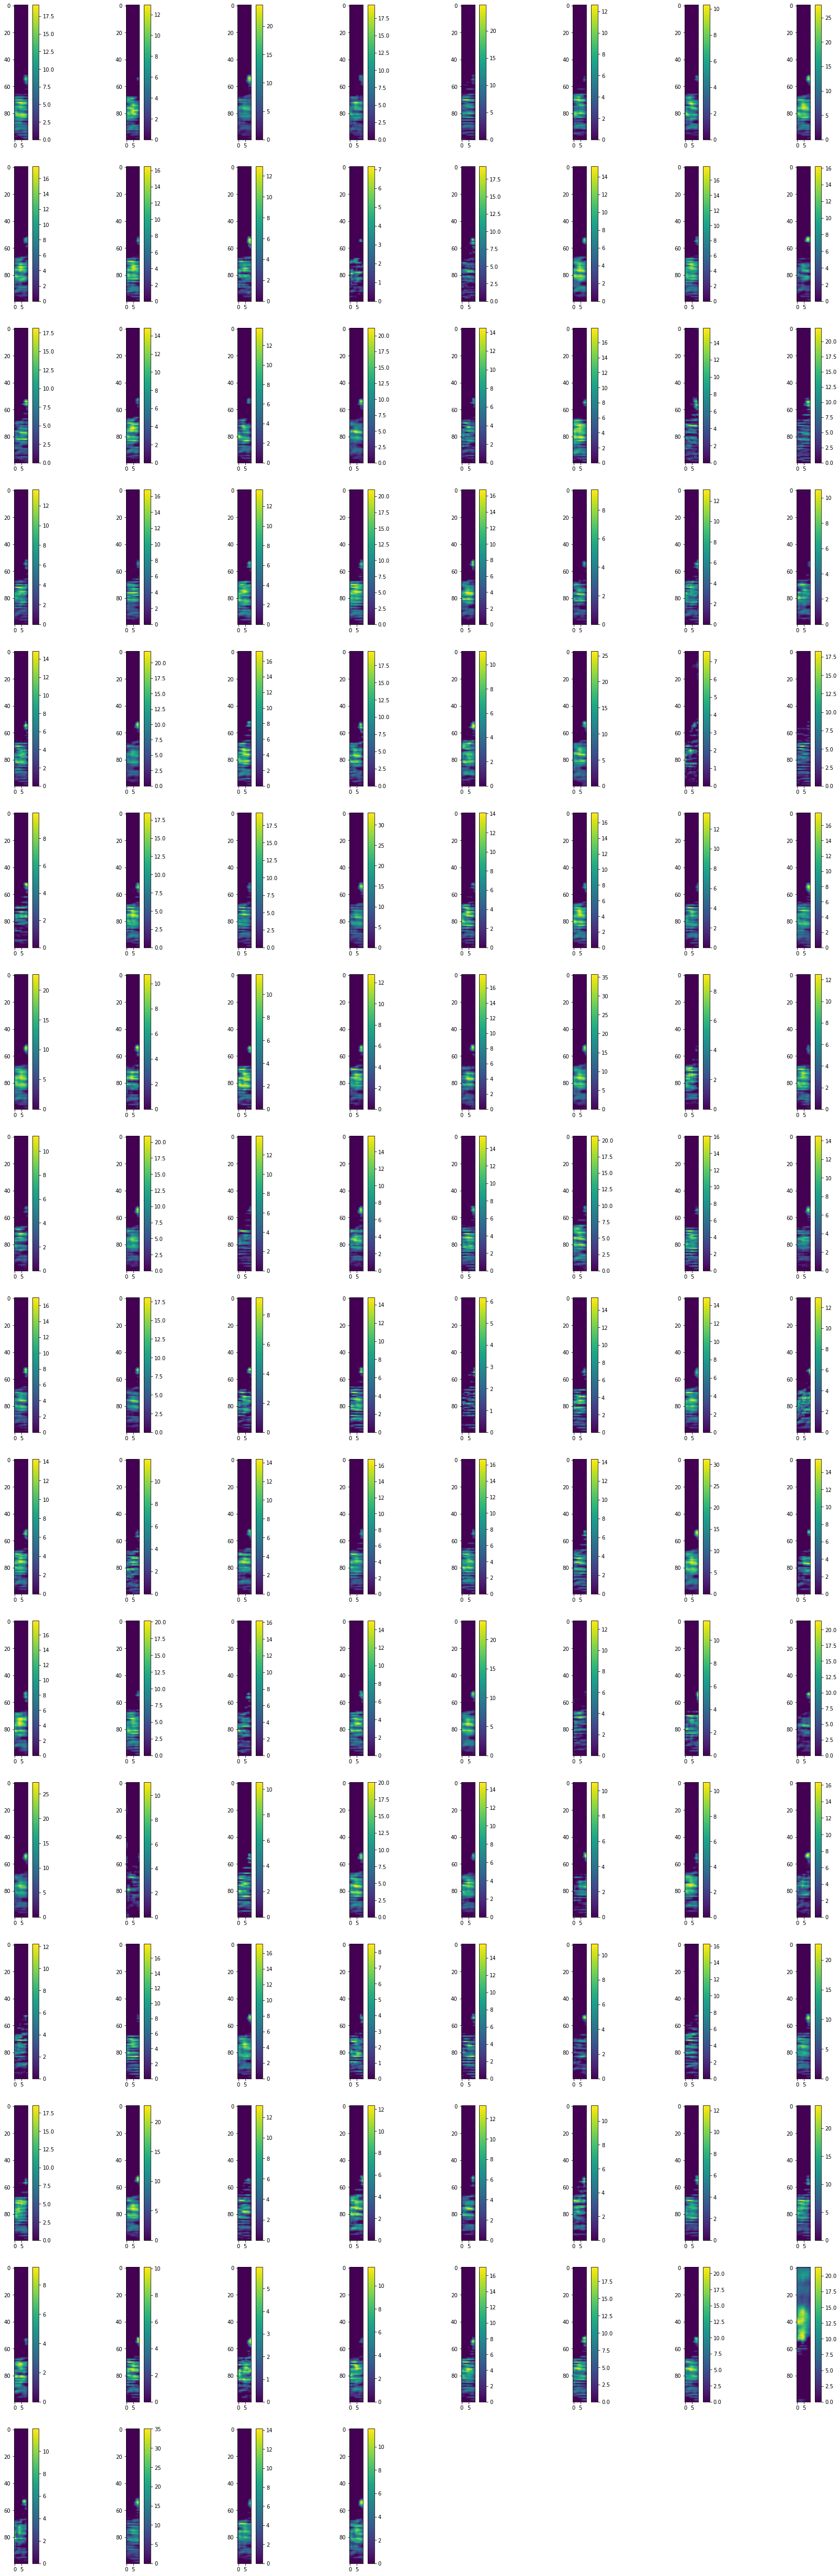

In [30]:
weights = conv1[0]
plt.figure(figsize=(30,90))
for i in range(124):
    weights_sub = weights[i].detach().cpu()
    weights_sub = torch.transpose(weights_sub,0,1)
    plt.subplot(16,8,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

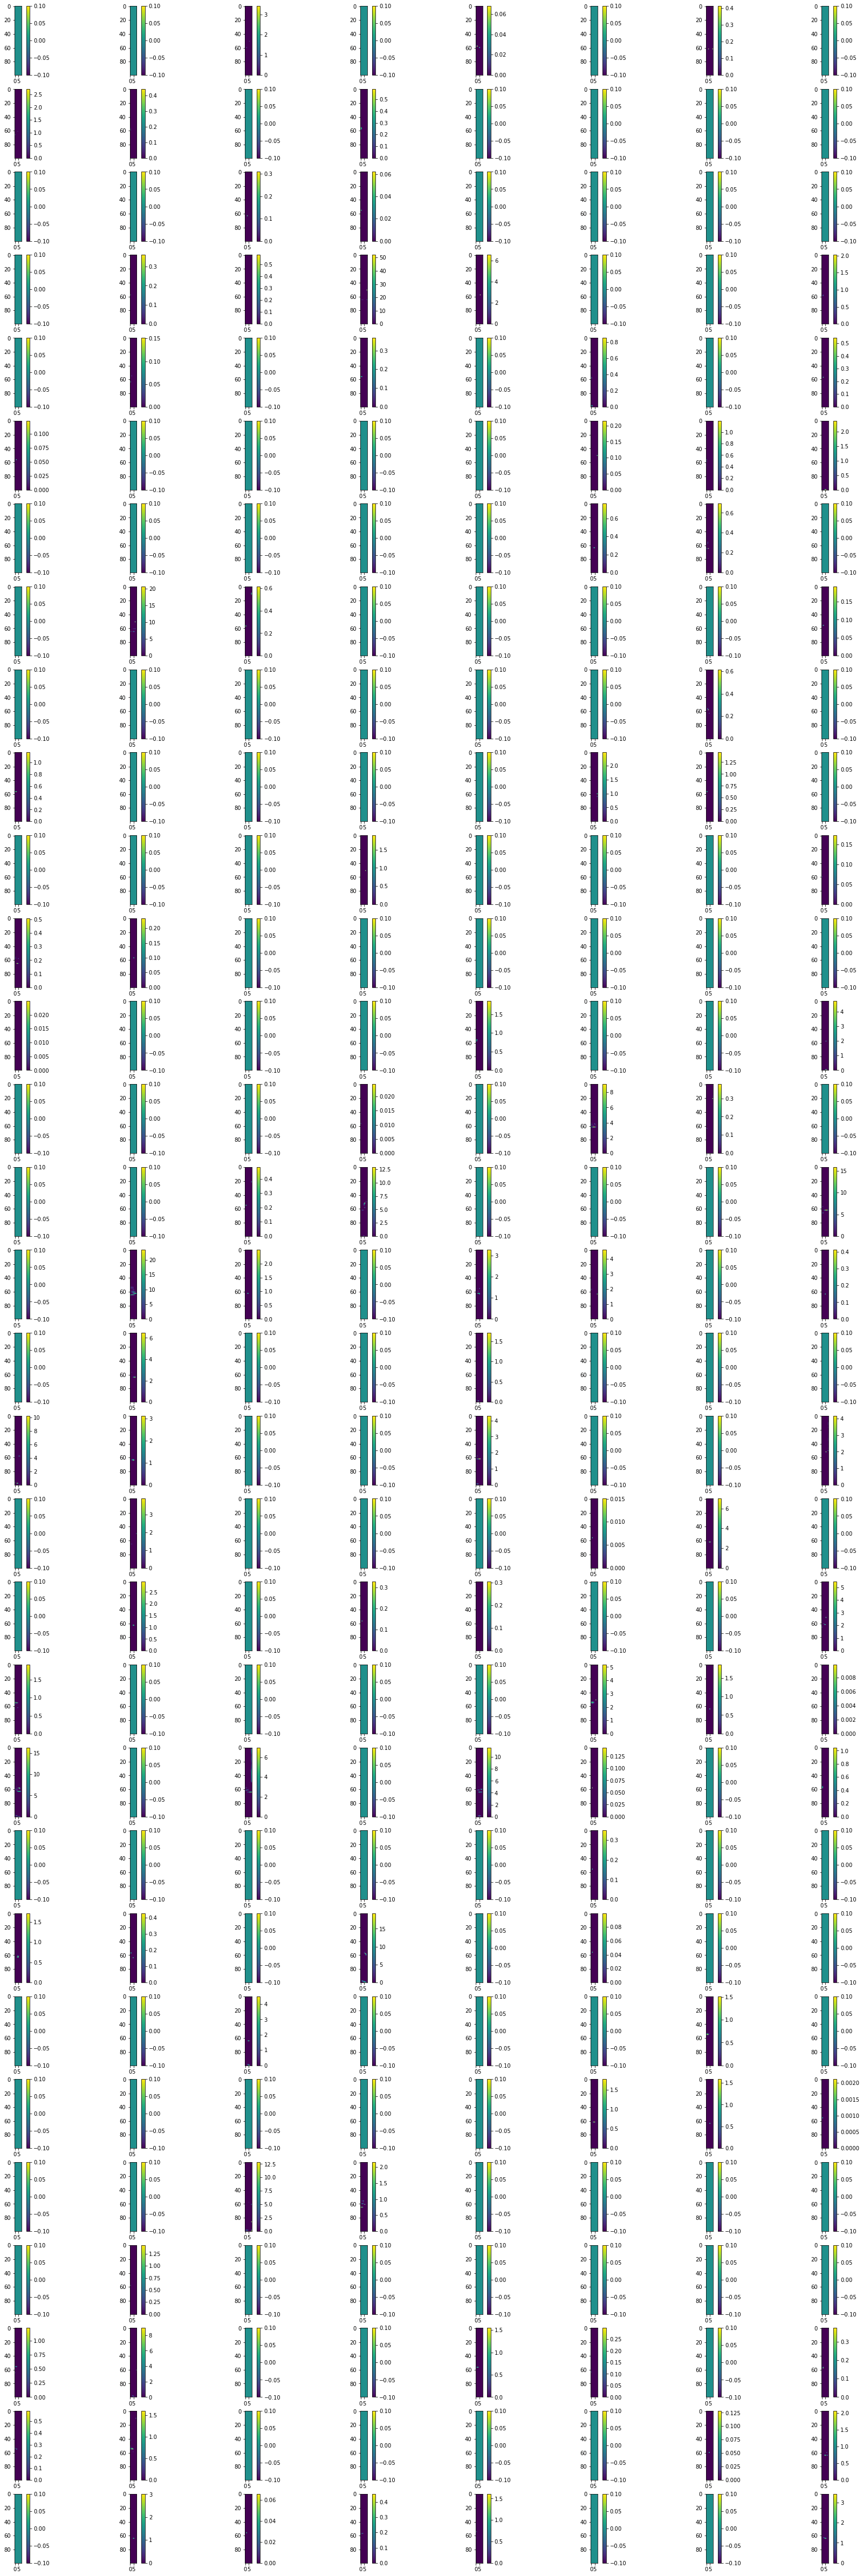

In [31]:
weights = conv2[0]
plt.figure(figsize=(30,90))
for i in range(248):
    weights_sub = weights[i].detach().cpu()
    weights_sub = torch.transpose(weights_sub,0,1)
    plt.subplot(32,8,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

# 1 layer CNN

In [23]:
class CNN_1layer(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNN_1layer, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=62, out_channels=124, kernel_size=(3,3), stride = (1,1), padding = (1,1))
#         self.conv2 = nn.Conv2d(in_channels=124, out_channels=248, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(124*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
#         x2 = relu(self.conv2(x1))
        x = x1.reshape(x1.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, torch.tensor(0)

In [26]:
model = CNN_1layer().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 9.679637908935547
Val loss for epoch 0: 10.779866218566895
Train loss for epoch 1: 15.602577209472656
Val loss for epoch 1: 16.09309959411621
Train loss for epoch 2: 14.846588134765625
Val loss for epoch 2: 11.537325859069824
Train loss for epoch 3: 13.012819290161133
Val loss for epoch 3: 12.653505325317383
Train loss for epoch 4: 13.664381980895996
Val loss for epoch 4: 11.573616981506348
Train loss for epoch 5: 16.682693481445312
Val loss for epoch 5: 19.36720085144043
Train loss for epoch 6: 15.336812973022461
Val loss for epoch 6: 11.285365104675293
Train loss for epoch 7: 16.201719284057617
Val loss for epoch 7: 39.7247314453125


KeyboardInterrupt: 

# MLP

In [39]:
class MLP(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
#         self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x1 = relu(self.fc1(x))
#         x = self.dropout(x)
        x2 = self.fc2(x1).flatten()
        x = self.sigmoid(x2)
        return x, x1, x2

In [40]:
model = MLP().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.351389616727829
Val loss for epoch 0: 0.35477524995803833
Train loss for epoch 1: 0.2985493838787079
Val loss for epoch 1: 0.2987966239452362
Train loss for epoch 2: 0.2842399775981903
Val loss for epoch 2: 0.27245521545410156
Train loss for epoch 3: 0.27603593468666077
Val loss for epoch 3: 0.2884346544742584
Train loss for epoch 4: 0.266607403755188
Val loss for epoch 4: 0.3210833966732025
Train loss for epoch 5: 0.2604256272315979
Val loss for epoch 5: 0.298595130443573
Train loss for epoch 6: 0.2611907422542572
Val loss for epoch 6: 0.31134048104286194
Train loss for epoch 7: 0.25345611572265625
Val loss for epoch 7: 0.256839394569397
Train loss for epoch 8: 0.25571054220199585
Val loss for epoch 8: 0.26954129338264465
Train loss for epoch 9: 0.2525424361228943
Val loss for epoch 9: 0.29652169346809387
Train loss for epoch 10: 0.24801984429359436
Val loss for epoch 10: 0.24762219190597534
Train loss for epoch 11: 0.24303653836250305
Val loss for epoch 11: 

Train loss for epoch 95: 0.17188453674316406
Val loss for epoch 95: 0.2842526137828827
Train loss for epoch 96: 0.17399786412715912
Val loss for epoch 96: 0.28070133924484253
Train loss for epoch 97: 0.17365626990795135
Val loss for epoch 97: 0.30902644991874695
Train loss for epoch 98: 0.17358684539794922
Val loss for epoch 98: 0.29516440629959106
Train loss for epoch 99: 0.16919228434562683
Val loss for epoch 99: 0.2953031063079834


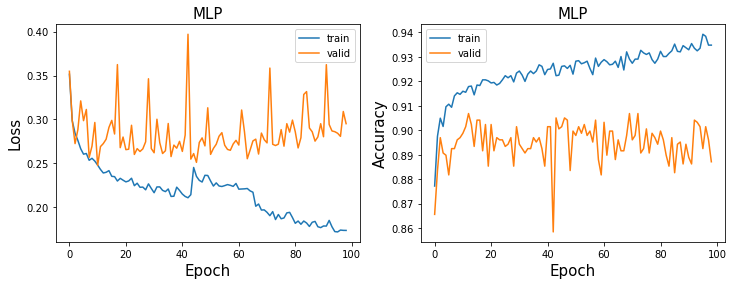

In [41]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("MLP", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("MLP", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [42]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, lin1, lin2 = model(data)
    break

In [47]:
lin1.shape

torch.Size([16, 200])

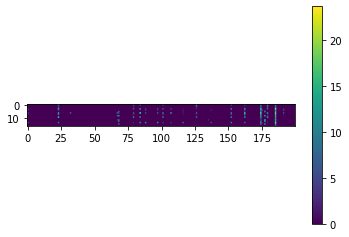

In [50]:
plt.imshow(lin1.detach().cpu())
plt.colorbar(orientation='vertical')
plt.show()

# MLP With Dropout Regularization

In [53]:
class MLPreg(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLPreg, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x1 = relu(self.fc1(x))
        x1 = self.dropout(x1)
        x2 = self.fc2(x1).flatten()
        x = self.sigmoid(x2)
        return x, x1, x2

In [63]:
model = MLPreg().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.3772211968898773
Val loss for epoch 0: 0.3278123736381531
Train loss for epoch 1: 0.3258798122406006
Val loss for epoch 1: 0.30433499813079834
Train loss for epoch 2: 0.3204501271247864
Val loss for epoch 2: 0.29887983202934265
Train loss for epoch 3: 0.3133679926395416
Val loss for epoch 3: 0.31950506567955017
Train loss for epoch 4: 0.31834959983825684
Val loss for epoch 4: 0.34759625792503357
Train loss for epoch 5: 0.30670642852783203
Val loss for epoch 5: 0.3211531341075897
Train loss for epoch 6: 0.2908598780632019
Val loss for epoch 6: 0.28400465846061707
Train loss for epoch 7: 0.30739960074424744
Val loss for epoch 7: 0.32486963272094727
Train loss for epoch 8: 0.29694539308547974
Val loss for epoch 8: 0.28444939851760864
Train loss for epoch 9: 0.2874487638473511
Val loss for epoch 9: 0.3225998878479004
Train loss for epoch 10: 0.2899821698665619
Val loss for epoch 10: 0.2800253927707672
Train loss for epoch 11: 0.28766584396362305
Val loss for epoch

Train loss for epoch 95: 0.24067211151123047
Val loss for epoch 95: 0.26960474252700806
Train loss for epoch 96: 0.242121621966362
Val loss for epoch 96: 0.2626241445541382
Train loss for epoch 97: 0.24833190441131592
Val loss for epoch 97: 0.2653689682483673
Train loss for epoch 98: 0.24029910564422607
Val loss for epoch 98: 0.2706611454486847
Train loss for epoch 99: 0.24227745831012726
Val loss for epoch 99: 0.25383538007736206


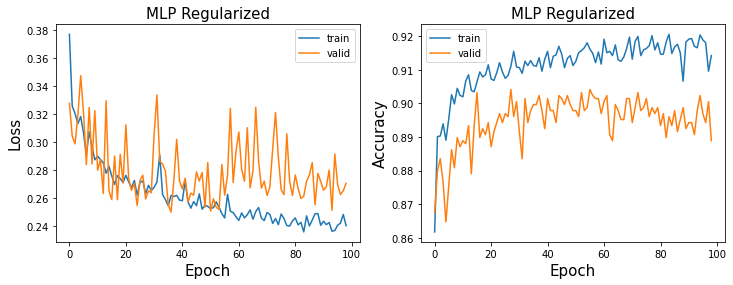

In [64]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("MLP Regularized", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("MLP Regularized", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [65]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, lin1, lin2 = model(data)
    break

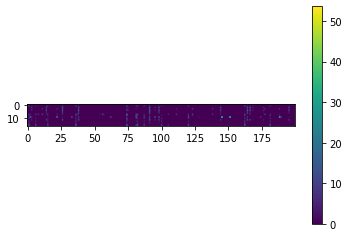

In [66]:
plt.imshow(lin1.detach().cpu())
plt.colorbar(orientation='vertical')
plt.show()

# MLP with Batchnorm

In [56]:
class MLPbatchnorm(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLPbatchnorm, self).__init__()
        self.fc1 = nn.Linear(100*10, 200)
        self.batchnorm = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], -1)
        x1 = relu(self.fc1(x))
        x1 = self.batchnorm(x1)
        x2 = self.fc2(x1).flatten()
        x = self.sigmoid(x2)
        return x, x1, x2

In [57]:
model = MLPbatchnorm().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.32257983088493347
Val loss for epoch 0: 0.308698832988739
Train loss for epoch 1: 0.2981615364551544
Val loss for epoch 1: 0.3285014033317566
Train loss for epoch 2: 0.2925729751586914
Val loss for epoch 2: 0.3121621608734131
Train loss for epoch 3: 0.2851932942867279
Val loss for epoch 3: 0.3011229634284973
Train loss for epoch 4: 0.28767284750938416
Val loss for epoch 4: 0.28711456060409546
Train loss for epoch 5: 0.28226056694984436
Val loss for epoch 5: 0.27578747272491455
Train loss for epoch 6: 0.28806957602500916
Val loss for epoch 6: 0.3050876259803772
Train loss for epoch 7: 0.27524349093437195
Val loss for epoch 7: 0.2786574065685272
Train loss for epoch 8: 0.27174705266952515
Val loss for epoch 8: 0.2649642825126648
Train loss for epoch 9: 0.2837471067905426
Val loss for epoch 9: 0.35710597038269043
Train loss for epoch 10: 0.2842882573604584
Val loss for epoch 10: 0.2818637788295746
Train loss for epoch 11: 0.2825322151184082
Val loss for epoch 11:

Train loss for epoch 95: 0.2128487229347229
Val loss for epoch 95: 0.3005782961845398
Train loss for epoch 96: 0.23314054310321808
Val loss for epoch 96: 0.2794048488140106
Train loss for epoch 97: 0.22167731821537018
Val loss for epoch 97: 0.25512048602104187
Train loss for epoch 98: 0.2226632982492447
Val loss for epoch 98: 0.27562955021858215
Train loss for epoch 99: 0.2302456796169281
Val loss for epoch 99: 0.27689534425735474


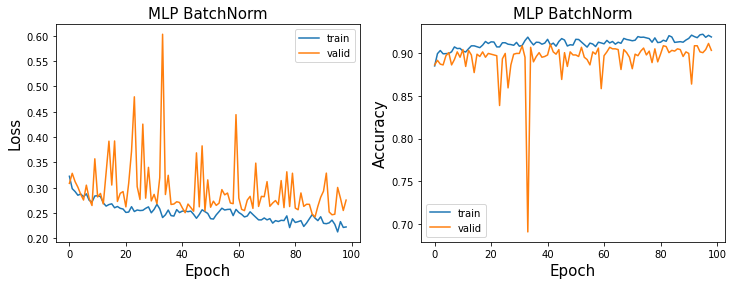

In [58]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("MLP BatchNorm", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("MLP BatchNorm", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [59]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, lin1, lin2 = model(data)
    break

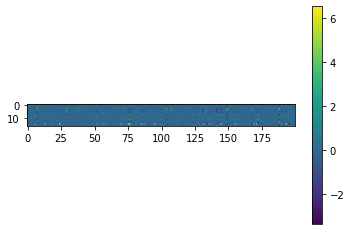

In [60]:
plt.imshow(lin1.detach().cpu())
plt.colorbar(orientation='vertical')
plt.show()

# 4 Layer CNN with Dropout Reg

In [71]:
class CNNdropout(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNNdropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout = nn.Dropout(0.5)
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(16*10*100, num_classes)
#         self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
        x2 = self.dropout(x2)
        x = relu(self.conv3(x2))
        x = relu(self.conv4(x))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [72]:
model = CNNdropout().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.38912904262542725
Val loss for epoch 0: 0.3250003457069397
Train loss for epoch 1: 0.31515973806381226
Val loss for epoch 1: 0.3058723509311676
Train loss for epoch 2: 0.304548978805542
Val loss for epoch 2: 0.3010948598384857
Train loss for epoch 3: 0.29673415422439575
Val loss for epoch 3: 0.3044283390045166
Train loss for epoch 4: 0.2855878472328186
Val loss for epoch 4: 0.32229235768318176
Train loss for epoch 5: 0.2805328071117401
Val loss for epoch 5: 0.3006100356578827
Train loss for epoch 6: 0.2767184376716614
Val loss for epoch 6: 0.2928425967693329
Train loss for epoch 7: 0.2715020775794983
Val loss for epoch 7: 0.28314098715782166
Train loss for epoch 8: 0.27249839901924133
Val loss for epoch 8: 0.30290380120277405
Train loss for epoch 9: 0.2688707113265991
Val loss for epoch 9: 0.3003004193305969
Train loss for epoch 10: 0.2669561505317688
Val loss for epoch 10: 0.2752572000026703
Train loss for epoch 11: 0.2607920169830322
Val loss for epoch 11: 0

Train loss for epoch 95: 0.17794384062290192
Val loss for epoch 95: 0.33110952377319336
Train loss for epoch 96: 0.1825053095817566
Val loss for epoch 96: 0.3255472779273987
Train loss for epoch 97: 0.17106254398822784
Val loss for epoch 97: 0.33541202545166016
Train loss for epoch 98: 0.1781393438577652
Val loss for epoch 98: 0.35285237431526184
Train loss for epoch 99: 0.17478761076927185
Val loss for epoch 99: 0.3326299786567688


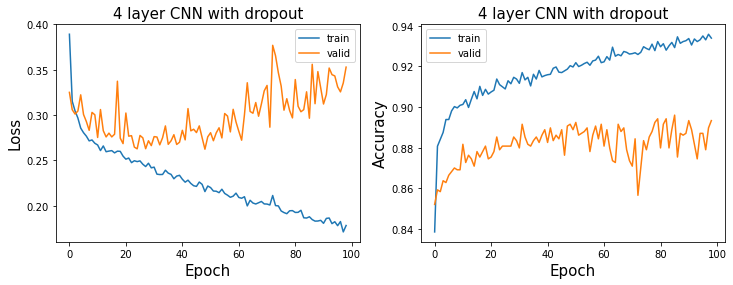

In [73]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("4 layer CNN with dropout", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("4 layer CNN with dropout", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

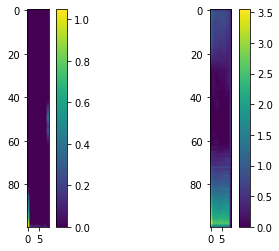

In [75]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

weights = conv1[0]
# plt.figure(figsize=(30,90))
for i in range(2):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,2,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

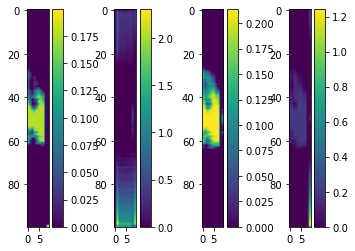

In [76]:
weights = conv2[0]
# plt.figure(figsize=(30,90))
for i in range(4):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,4,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

In [27]:
class CNNsmalldropout(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNNsmalldropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=62, out_channels=124, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=124, out_channels=248, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout = nn.Dropout(0.5)
#         self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride = (1,1), padding = (1,1))
#         self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride = (1,1), padding = (1,1))
#         self.fc1 = nn.Linear(16*10*100, num_classes)
        self.fc1 = nn.Linear(248*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
#         x = relu(self.conv3(x2))
#         x = relu(self.conv4(x))
        x2 = self.dropout(x2)
        x = x2.reshape(x2.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [28]:
model = CNNsmalldropout().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.4992521107196808
Val loss for epoch 0: 0.3675307333469391
Train loss for epoch 1: 0.29579755663871765
Val loss for epoch 1: 0.31398913264274597
Train loss for epoch 2: 0.23249688744544983
Val loss for epoch 2: 0.2525550127029419
Train loss for epoch 3: 0.19747017323970795
Val loss for epoch 3: 0.28486618399620056
Train loss for epoch 4: 0.1695651412010193
Val loss for epoch 4: 0.3172093629837036
Train loss for epoch 5: 0.15816384553909302
Val loss for epoch 5: 0.3956744968891144
Train loss for epoch 6: 0.16971592605113983
Val loss for epoch 6: 0.6854187846183777
Train loss for epoch 7: 0.12845727801322937
Val loss for epoch 7: 0.7457703351974487
Train loss for epoch 8: 0.11836021393537521
Val loss for epoch 8: 0.6066073179244995
Train loss for epoch 9: 0.15240749716758728
Val loss for epoch 9: 0.9892690181732178
Train loss for epoch 10: 0.13768494129180908
Val loss for epoch 10: 0.8828116655349731
Train loss for epoch 11: 0.11484657973051071
Val loss for epoch

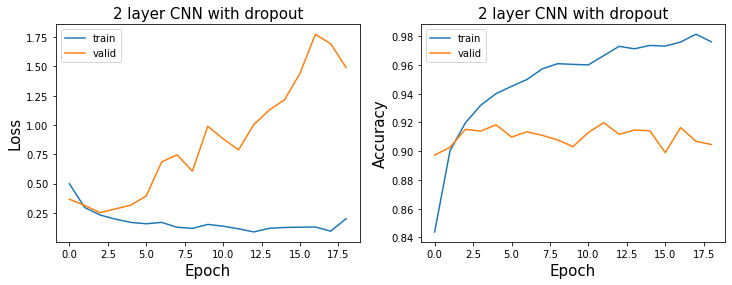

In [29]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("2 layer CNN with dropout", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("2 layer CNN with dropout", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

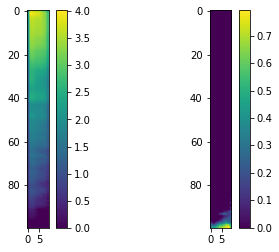

In [83]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

weights = conv1[0]
# plt.figure(figsize=(30,90))
for i in range(2):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,2,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

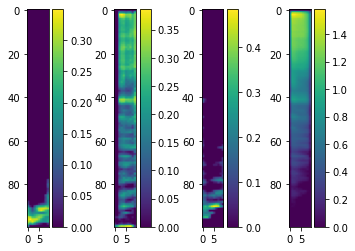

In [84]:
weights = conv2[0]
# plt.figure(figsize=(30,90))
for i in range(4):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,4,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

# 4 layer CNN with batchnorm2d

In [88]:
class CNNbatchnorm(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNNbatchnorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout = nn.BatchNorm2d(4)
        self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(16*10*100, num_classes)
#         self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
        x2 = self.dropout(x2)
        x = relu(self.conv3(x2))
        x = relu(self.conv4(x))
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [89]:
model = CNNbatchnorm().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.430553138256073
Val loss for epoch 0: 0.41060250997543335
Train loss for epoch 1: 0.3477221429347992
Val loss for epoch 1: 0.38094407320022583
Train loss for epoch 2: 0.3355570435523987
Val loss for epoch 2: 0.3435440957546234
Train loss for epoch 3: 0.31170564889907837
Val loss for epoch 3: 0.3286226689815521
Train loss for epoch 4: 0.289164274930954
Val loss for epoch 4: 0.30129870772361755
Train loss for epoch 5: 0.2740776240825653
Val loss for epoch 5: 0.32515332102775574
Train loss for epoch 6: 0.2605830729007721
Val loss for epoch 6: 0.34628230333328247
Train loss for epoch 7: 0.246947780251503
Val loss for epoch 7: 0.2842245399951935
Train loss for epoch 8: 0.24204720556735992
Val loss for epoch 8: 0.3246677815914154
Train loss for epoch 9: 0.23216179013252258
Val loss for epoch 9: 0.3443690538406372
Train loss for epoch 10: 0.2188340574502945
Val loss for epoch 10: 0.3038100600242615
Train loss for epoch 11: 0.20920854806900024
Val loss for epoch 11: 0

Train loss for epoch 94: 0.0001038270493154414
Val loss for epoch 94: 2.2264626026153564
Train loss for epoch 95: 0.0003348934988025576
Val loss for epoch 95: 2.2232117652893066
Train loss for epoch 96: 0.00011981552961515263
Val loss for epoch 96: 2.361034631729126
Train loss for epoch 97: 0.037781309336423874
Val loss for epoch 97: 1.8351606130599976
Train loss for epoch 98: 0.03154606372117996
Val loss for epoch 98: 1.6895161867141724
Train loss for epoch 99: 0.011911206878721714
Val loss for epoch 99: 1.7771592140197754


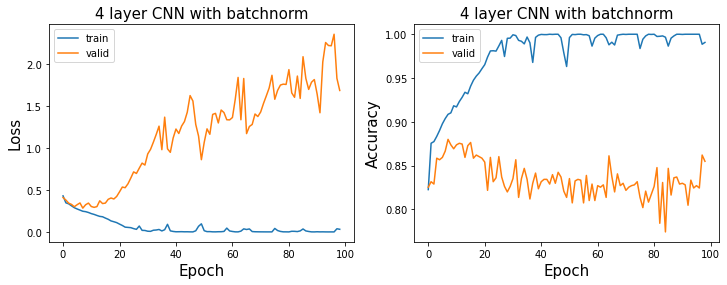

In [90]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("4 layer CNN with batchnorm", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("4 layer CNN with batchnorm", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

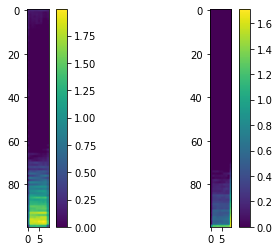

In [91]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

weights = conv1[0]
# plt.figure(figsize=(30,90))
for i in range(2):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,2,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

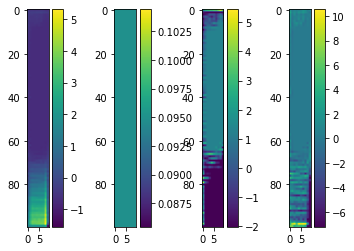

In [94]:
weights = conv2[0]
# plt.figure(figsize=(30,90))
for i in range(4):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,4,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

# 2 layer CNN with Batchnorm

In [108]:
class CNNsmallbatchnorm(nn.Module):
    def __init__(self, in_channels = 1, num_classes = 1):
        super(CNNsmallbatchnorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.conv2 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=(3,3), stride = (1,1), padding = (1,1))
        self.dropout = nn.Batchnorm(4)
#         self.conv3 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3,3), stride = (1,1), padding = (1,1))
#         self.conv4 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), stride = (1,1), padding = (1,1))
#         self.fc1 = nn.Linear(16*10*100, num_classes)
        self.fc1 = nn.Linear(4*10*100, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float()
        x1 = relu(self.conv1(x))
        x2 = relu(self.conv2(x1))
#         x = relu(self.conv3(x2))
#         x = relu(self.conv4(x))
        x2 = self.dropout(x2)
        x = x2.reshape(x2.shape[0], -1)
        x = self.fc1(x).flatten()
        x = self.sigmoid(x)
        return x, x1, x2

In [109]:
model = CNNbatchnorm().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.3904516100883484
Val loss for epoch 0: 0.37954652309417725
Train loss for epoch 1: 0.33092591166496277
Val loss for epoch 1: 0.3800124228000641
Train loss for epoch 2: 0.30130475759506226
Val loss for epoch 2: 0.28867200016975403
Train loss for epoch 3: 0.28482601046562195
Val loss for epoch 3: 0.2960590422153473
Train loss for epoch 4: 0.2751152217388153
Val loss for epoch 4: 0.2841906249523163
Train loss for epoch 5: 0.26600348949432373
Val loss for epoch 5: 0.31010907888412476
Train loss for epoch 6: 0.26013731956481934
Val loss for epoch 6: 0.27137190103530884
Train loss for epoch 7: 0.2559688091278076
Val loss for epoch 7: 0.30985549092292786
Train loss for epoch 8: 0.2506241500377655
Val loss for epoch 8: 0.32006019353866577
Train loss for epoch 9: 0.2395159751176834
Val loss for epoch 9: 0.32638388872146606
Train loss for epoch 10: 0.23970048129558563
Val loss for epoch 10: 0.2719000279903412
Train loss for epoch 11: 0.23235715925693512
Val loss for epo

Train loss for epoch 94: 0.0034044950734823942
Val loss for epoch 94: 1.6119205951690674
Train loss for epoch 95: 0.0005320724449120462
Val loss for epoch 95: 2.0687854290008545
Train loss for epoch 96: 0.0012497681891545653
Val loss for epoch 96: 2.046644926071167
Train loss for epoch 97: 0.0021698204800486565
Val loss for epoch 97: 1.6792073249816895
Train loss for epoch 98: 0.04148110747337341
Val loss for epoch 98: 1.294152855873108
Train loss for epoch 99: 0.019964730367064476
Val loss for epoch 99: 1.4338304996490479


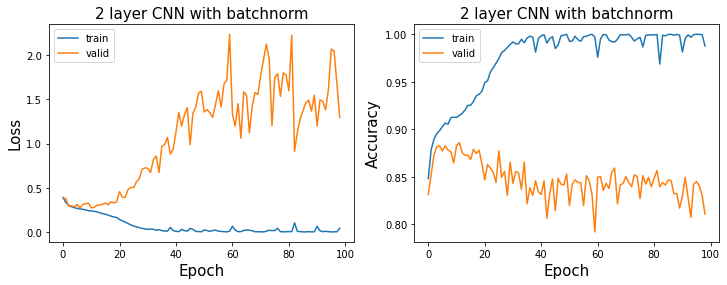

In [110]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("2 layer CNN with batchnorm", fontsize = 15)
plt.plot(training_losses[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_losses[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("2 layer CNN with batchnorm", fontsize = 15)
plt.plot(training_acc[:-1],linewidth = 1.5,label = 'train')
plt.plot(val_acc[:-1],linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

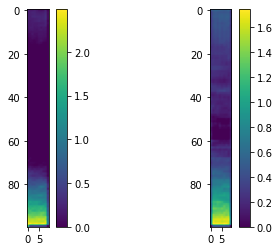

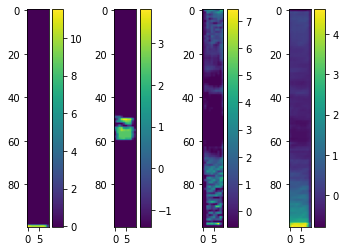

In [111]:
for batch_idx, (data, labels, date, rec, win) in enumerate(train_loader):
    data = data.to(device)
    x, conv1, conv2 = model(data)
    break

weights = conv1[0]
# plt.figure(figsize=(30,90))
for i in range(2):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,2,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

weights = conv2[0]
# plt.figure(figsize=(30,90))
for i in range(4):
    weights_sub = weights[i].detach().cpu()
    plt.subplot(1,4,i+1)
    plt.imshow(weights_sub)
    plt.colorbar(orientation='vertical')
plt.show()

# Checking models can learn single example

In [49]:
# def __init__(self, mode='train',moving_files_train=moving_files_train,sleeping_files_train=sleeping_files_train,moving_files_val=moving_files_val,sleeping_files_val=sleeping_files_val):
train_dataset_single = NoahSpectrogramDataset(mode='train', moving_files_train=moving_files_train[:1], sleeping_files_train=[], moving_files_val=moving_files_train[:1], sleeping_files_val=[])
valid_dataset_single = NoahSpectrogramDataset(mode='valid', moving_files_train=moving_files_train[:1], sleeping_files_train=[], moving_files_val=moving_files_train[:1], sleeping_files_val=[])

In [50]:
train_loader_single = DataLoader(dataset = train_dataset_single, batch_size = 1, shuffle = True)
val_loader_single = DataLoader(dataset = valid_dataset_single, batch_size = 1, shuffle = False)

In [51]:
model = CNNsplit().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader_single, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader_single, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.7039603590965271
Val loss for epoch 0: 0.42136335372924805
Train loss for epoch 1: 0.42136335372924805
Val loss for epoch 1: 0.22744160890579224
Train loss for epoch 2: 0.22744160890579224
Val loss for epoch 2: 0.11093311011791229
Train loss for epoch 3: 0.11093311011791229
Val loss for epoch 3: 0.05015068128705025
Train loss for epoch 4: 0.05015068128705025
Val loss for epoch 4: 0.021632274612784386
Train loss for epoch 5: 0.021632274612784386
Val loss for epoch 5: 0.009121827781200409
Train loss for epoch 6: 0.009121827781200409
Val loss for epoch 6: 0.003833898575976491
Train loss for epoch 7: 0.003833898575976491
Val loss for epoch 7: 0.0016287709586322308
Train loss for epoch 8: 0.0016287709586322308
Val loss for epoch 8: 0.0007062663789838552
Train loss for epoch 9: 0.0007062663789838552
Val loss for epoch 9: 0.000314702425384894
Train loss for epoch 10: 0.000314702425384894
Val loss for epoch 10: 0.00014473055489361286
Train loss for epoch 11: 0.0001447

In [60]:
model = MLP().to(device)
# model.apply(weight_reset)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

training_losses = []
val_losses = []
training_acc = []
val_acc = []

train_predictions = []
validation_predictions = []
train_labels = []
validation_labels = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy, train_preds, train_labs = train(train_loader_single, epoch)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy, val_preds, val_labels = test(val_loader_single, epoch)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
    
    train_predictions.append(train_preds)
    train_labels.append(train_labs)
    validation_predictions.append(val_preds)
    validation_labels.append(val_labels)

Train loss for epoch 0: 0.6323049068450928
Val loss for epoch 0: 0.12737344205379486
Train loss for epoch 1: 0.12737344205379486
Val loss for epoch 1: 0.038932040333747864
Train loss for epoch 2: 0.038932040333747864
Val loss for epoch 2: 0.015314060263335705
Train loss for epoch 3: 0.015314060263335705
Val loss for epoch 3: 0.00675048865377903
Train loss for epoch 4: 0.00675048865377903
Val loss for epoch 4: 0.003244113177061081
Train loss for epoch 5: 0.003244113177061081
Val loss for epoch 5: 0.001679220236837864
Train loss for epoch 6: 0.001679220236837864
Val loss for epoch 6: 0.0009269240545108914
Train loss for epoch 7: 0.0009269240545108914
Val loss for epoch 7: 0.0005412374157458544
Train loss for epoch 8: 0.0005412374157458544
Val loss for epoch 8: 0.0003321126278024167
Train loss for epoch 9: 0.0003321126278024167
Val loss for epoch 9: 0.00021299008221831173
Train loss for epoch 10: 0.00021299008221831173
Val loss for epoch 10: 0.00014204795297700912
Train loss for epoch 11:

In [73]:
model

MLP(
  (fc1): Linear(in_features=1000, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [79]:
model.fc1.weight.shape

torch.Size([200, 1000])